<a href="https://colab.research.google.com/github/daost2001/X-ray-image-classification/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model
from PIL import Image

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload() #get api token from kaggle and upload kaggle.json file

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download paultimothymooney/chest-xray-pneumonia

! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
train_directory= "chest_xray/chest_xray/train/"
val_directory="chest_xray/chest_xray/val/"
test_directory="chest_xray/chest_xray/test/"

In [ ]:
data_dir = train_directory
class_names=os.listdir(train_directory)
class_names.pop()
print(class_names)

['PNEUMONIA', 'NORMAL']


In [ ]:
def view_random_image(target_directory, target_class):
    target_folder = target_directory + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    return img

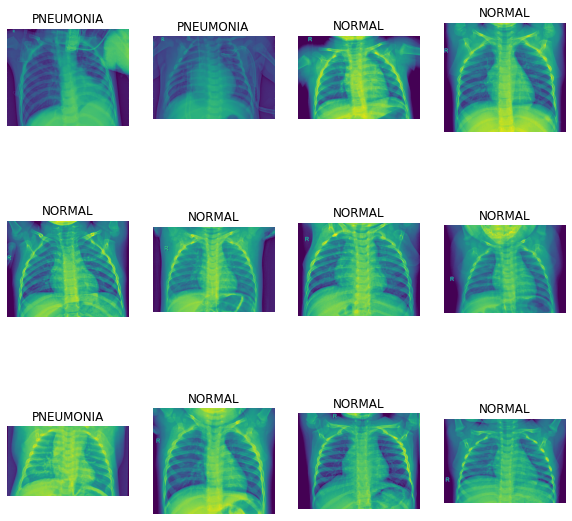

In [ ]:
plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    r=random.randint(0,1)
    img = view_random_image(data_dir, class_names[r])  

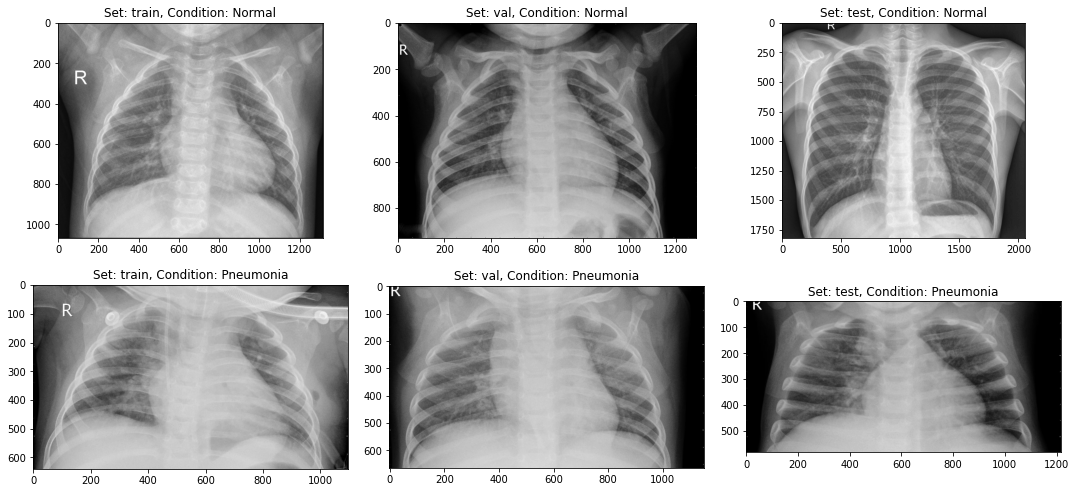

In [ ]:
input_path="chest_xray/chest_xray/"
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[1]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [ ]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1342, pneumonia images: 3876
Set: val, Normal images: 9, pneumonia images: 9
Set: test, Normal images: 234, pneumonia images: 390


In [ ]:
# Re-sizing the images
IMAGE_SIZE = (224, 224,3)
# Default batch size
BATCH_SIZE = 32

In [ ]:
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [ ]:
train = Image_gen.flow_from_directory(train_directory,
                                       batch_size=32,
                                       class_mode='binary',
                                       target_size=(224,224))
                                       

validation = Image_gen.flow_from_directory(val_directory,
                                              batch_size=16,
                                              class_mode='binary',
                                             target_size=(224,224))
                                            

test = val_Datagen.flow_from_directory(test_directory,
                                       batch_size=16,
                                       class_mode='binary',
                                       target_size=(224,224))
                                      

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
img, label = next(train)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

In [ ]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

In [ ]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [ ]:
initial_bias = np.log([n_infect/n_normal])
initial_bias

array([0.51082562])

In [ ]:
res_model = create_model()

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history = res_model.fit(train,epochs=5, 
                    validation_data=validation,
                     steps_per_epoch=5,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/5
5/5 [==============================] - 28s 4s/step - loss: 0.7436 - accuracy: 0.6187 - val_loss: 0.9399 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/5
5/5 [==============================] - 18s 4s/step - loss: 0.3589 - accuracy: 0.8375 - val_loss: 0.6575 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/5
5/5 [==============================] - 19s 4s/step - loss: 0.3780 - accuracy: 0.8313 - val_loss: 1.1808 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/5
5/5 [==============================] - 19s 4s/step - loss: 0.3181 - accuracy: 0.8625 - val_loss: 0.5424 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/5
5/5 [==============================] - 18s 4s/step - loss: 0.3128 - accuracy: 0.8687 - val_loss: 0.8318 - val_accuracy: 0.5000 - lr: 0.0010


Text(0, 0.5, 'Loss')

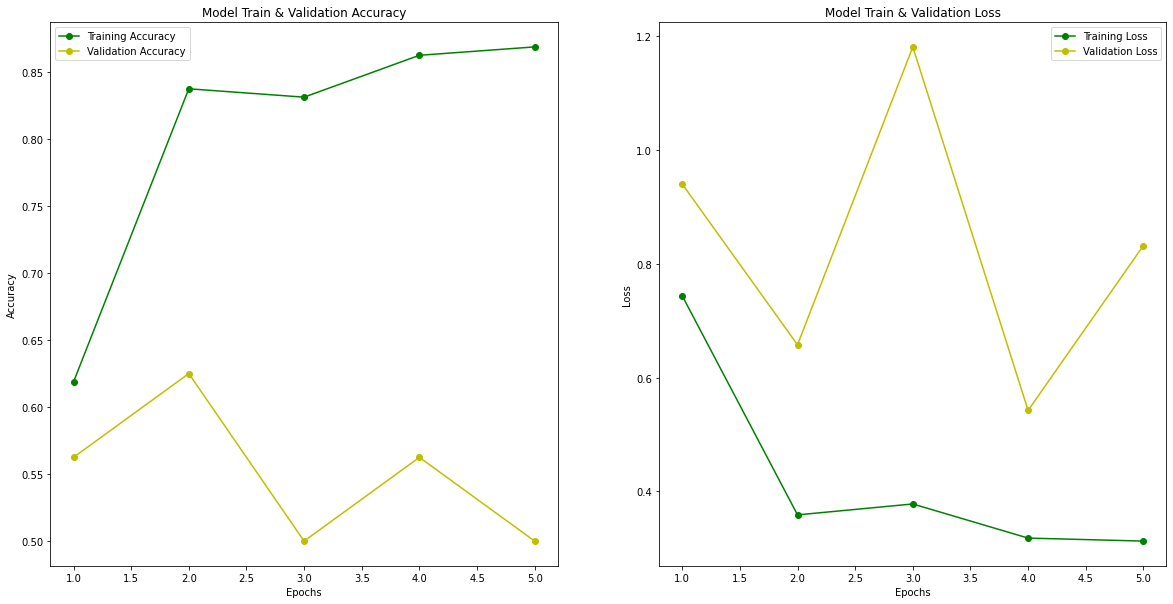

In [ ]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

In [ ]:
# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images[i])
#     img_array = tf.expand_dims(img_array,i)
#     # img_array = tf.expand_dims(img_array,1)
#     predictions = model.predict(img_array)

#     predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(100 * (np.max(predictions[0])), 2)
#     return predicted_class, confidence

# plt.figure(figsize=(15, 15))

# for images, labels in test:
#     for i in range(6):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i])


#         actual_class = class_names[int(labels[i])] 
#         predicted_class, confidence = predict(res_model, images[i])

#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

#         plt.axis("off")
#     break

1/1 [==============================] - 0s 140ms/step


UnboundLocalError: ignored

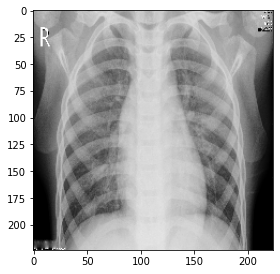

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])

    #img_array = tf.expand_dims(img_array,1)


    try:
      predictions = model.predict(img_array)
      predicted_class = class_names[np.argmax(predictions[0])]
    except:
      try:
        img_array = tf.expand_dims(img_array,i)
        predictions = model.predict(img_array)
      except:
        img_array = tf.expand_dims(img_array,1)
        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions[0])]
     


    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
plt.figure(figsize=(15, 15))

for images, labels in test:
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])


        actual_class = class_names[int(labels[i])] 
        predicted_class, confidence = predict(res_model, images[i])

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

In [ ]:
import glob
from pathlib import Path
import cv2
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix

normal_cases_dir = Path("chest_xray/chest_xray/test/NORMAL")
pneumonia_cases_dir = Path("chest_xray/chest_xray/test/PNEUMONIA")

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
test_data = []
test_labels = []
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)



test_data = np.array(test_data)
test_labels = np.array(test_labels)
print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

In [ ]:
y_test_hat = res_model.predict(test, batch_size=16)
y_test_hat = np.argmax(y_test_hat, axis=1)

In [ ]:
preds = res_model.predict(test_data, batch_size=16,verbose=1)
preds=np.around(preds)
orig_test_labels=test_labels

In [ ]:
# Evaluating the model on train and test
score = res_model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = res_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

score = res_model.evaluate(validation)
print("\nValidation loss: ", score[0])
print("Validation Accuracy: ", score[1])

In [ ]:
orig_test_labels = np.argmax(test_labels, axis=-1)
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()